In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

lambda_0: 1000.0 µm


/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_23621/2840123276.py:61: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(frequencies[0], frequencies[-1])


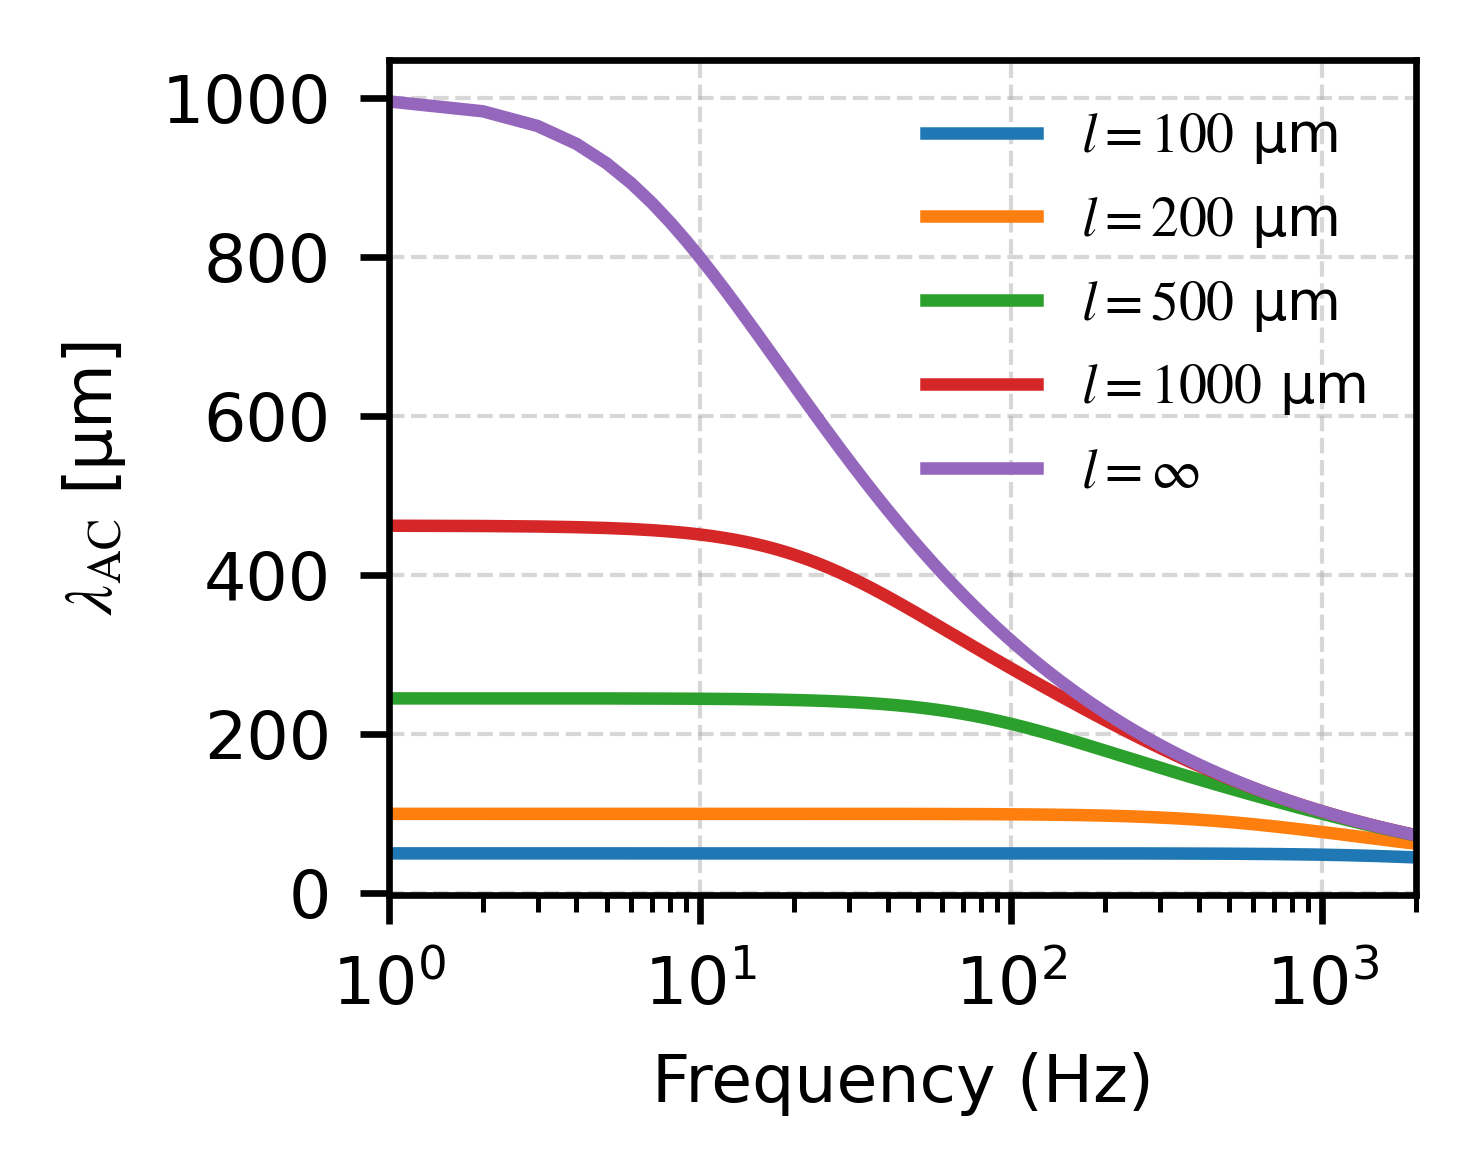

In [25]:
#Adapted from ElectricBrainSignals (Hagen and Ness 2023) Fig 3.7, see README

# Constants
d_fixed = 2e-6  # constant diameter for ax2
R_m = 3e4 * 1e-4  # Ohm cm² -> Ohm m²
R_i = 150 * 1e-2  # Ohm cm -> Ohm m
C_m = 1 * 1e-2  # uF / cm² -> F / m²

frequencies = np.arange(2001)
omegas = 2 * np.pi * frequencies
tau = R_m * C_m
s = np.sqrt(1 + 1j * omegas * tau)

# lambda_inf: used for normalization in ax2
lambda_0 = np.sqrt(d_fixed * R_m / (4 * R_i))
print('lambda_0:', lambda_0*1e6, 'µm')
lambda_ac_inf = lambda_0 * np.sqrt(2 / (1 + np.sqrt(1 + (omegas * tau)**2)))

def return_abs_H(s_, z_, l=1e-3, d=2e-6):
    lambda_0 = np.sqrt(d * R_m / (4 * R_i))
    exp_1 = 2 * s_ * l / lambda_0
    exp_2 = s_ * z_ / lambda_0

    if exp_1 > 30:
        term1 = 0 + 0j
    else:
        term1 = np.exp(+exp_2) / (1 + np.exp(exp_1))
    term2 = np.exp(-exp_2) / (1 + np.exp(-exp_1))

    H = np.pi * s_**2 * d / R_m * (term1 + term2)
    return np.abs(H)

def return_abs_H_matrix(s, z, l, d):
    H = np.zeros((len(z), len(s)), dtype=complex)
    for s_idx in range(len(s)):
        H[:, s_idx] = return_abs_H(s[s_idx], z, l, d)
    return H

# --- Plot only subplot B (fixed diameter, different lengths) ---
fig, ax = plt.subplots(figsize=(2.5, 2))
ax.set_xlim([0, 2000])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$\lambda_{\rm AC}$ [µm]")
# ax.set_title("diameter = 2 µm:")

# lengths to plot (m)
ls = [0.1e-3, 0.2e-3, 0.5e-3, 1.0e-3]
for l in ls:
    z_ = np.linspace(0, l, 1000)
    H_abs = return_abs_H_matrix(s, z_, l, d_fixed)
    # weighted average along z
    lambda_ac = np.abs(np.trapz(z_[:, None] * H_abs, z_, axis=0) / np.trapz(H_abs, z_, axis=0))
    ax.semilogx(frequencies, lambda_ac *1e6, label=f"$l={l*1e6:.0f}$ µm")

# plot lambda_inf normalized
ax.semilogx(frequencies, lambda_ac_inf *1e6, label=r"$l = \infty$")

ax.legend(frameon=False, loc='upper right', fontsize='small')
ax.grid(True, ls = '--', lw = '0.5', alpha = 0.5)

ax.set_xlim(frequencies[0], frequencies[-1])
plt.tight_layout()
fig.savefig("/Users/susannedahle/Documents/Master/Code/fig_pdfs/fig5.pdf")
plt.show()
